# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** xx

**Author 1 (sciper):** Camillo Nicolò De Sabbata (335004)  
**Author 2 (sciper):** Gianluca Radi (334736)   
**Author 3 (sciper):** Alessandro Dalbesio (352298)   

**Release date:** 8.03.2023  
**Due date:** 24.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'labs/data')
print(data_base_path)
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

../labs/data


---
## Part 1: Segmentation


### 1.0 Intro

In this exercise, you will be given two images. 

* `mucinous_adeno.jpg`: The image depicts a tissue sample from mucinous adenocarcinoma in colorectal cancer. The data is taken from the Cancer Genome Atlas (TCGA) which is an open-source database of different cancer types. Here you can see a tissue taken from a patient and stained using hematoxylin (purple) and eosin (pink) staining. The hematoxylin stains cell nuclei with a purplish blue, and the eosin stains the extracellular matrix and cytoplasm in pink.

* `mucinous_adeno_gt.jpg`: The second image is a coarse annotation of what is regarded as the so-called mucinous area. The mucinous area can be identified as a gray area tainted with purple. The presence of a large amount of mucin is a sign of a defect of normal epithelial cells that start to produce an unreasonable amount of mucin.


### 1.1 Tasks

You will be asked to extract the mucinous area using various approaches:

- [ ] Thresholding
- [ ] Morphology
- [ ] Region growing


### 1.1 Brain image visualization

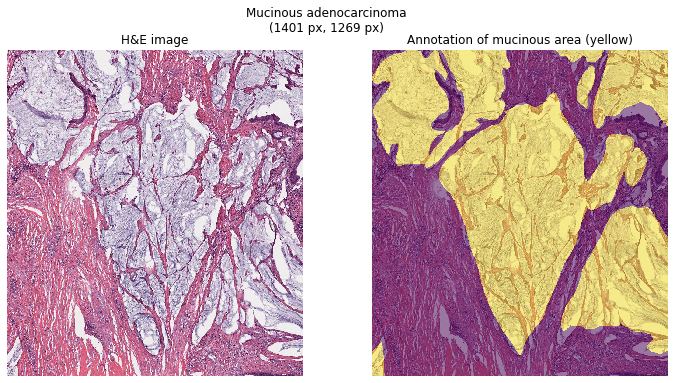

In [3]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load images
path_to_image = os.path.join(data_base_path, data_folder, "mucinous_adeno.jpg")
path_to_gt = os.path.join(data_base_path, data_folder, "mucinous_adeno_gt.jpg")
adeno_img = skimage.io.imread(path_to_image)
adeno_gt = skimage.io.imread(path_to_gt) > 128

# Get size of the image in px
im_h, im_w, im_c = adeno_img.shape

# Display MRI image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

# Plot image with overlay
ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')
plt.suptitle("Mucinous adenocarcinoma\n({} px, {} px)".format(im_h, im_w))
plt.show()

---
### 1.2 Thresholding (4pts)
#### 1.2.1 RGB & Hue (1 pts)

Display the histogram for each channel (R, G, and B) as well as the histogram for the H (hue) channel. Note that you can use [rgb2hsv](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2hsv) to convert an RGB image to an HSV image and then extract the hue.

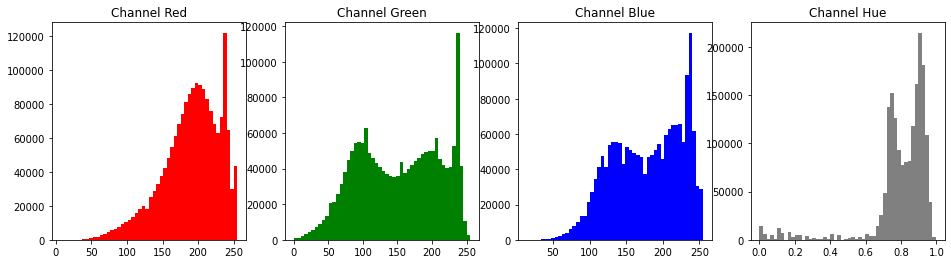

In [4]:

# Display HSV image histogram
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
channel_name = ['Red', 'Green', 'Blue']
for i in range(3):
    ax[i].hist(adeno_img[:, :, i].flatten(), bins=50, color=channel_name[i].lower())
    ax[i].set_title('Channel {}'.format(channel_name[i]))
hsv_image = skimage.color.rgb2hsv(adeno_img)
ax[3].hist(hsv_image[:, :, 0].flatten(), bins=50, color='grey')
ax[3].set_title('Channel Hue')
plt.suptitle('')
plt.show()

#### 1.2.2 Apply Thresholding (2 pts)

For each histogram find the threshold(s) that work the best to isolate the mucinous area. Display the image after thresholding of each channel as well as the error between your prediction ($im$) and the annotations ($gt$) using the formula:

$$error = 1 - \left( \frac{1}{IJ} \sum_{i,j} im_{i,j} == gt_{i, j} \right)$$

Here, I and J are the dimension of the image.

In [5]:
print(adeno_gt)

[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


In [6]:
def error_rate(mask, gt):
    """Compute error rate between ground truth and prediction.
    
    Args:
        mask: predicted mask
        gt: ground truth mask

    Returns:
        error rate
    """
    return (mask != gt).mean()

In [7]:
from skimage import filters
# Compute threshold for each channel
channel_name = ['Red', 'Green', 'Blue', 'Hue']
threshold_names = ["Isodata", "Li", "Minimum", "Mean", "Triangle", "Yen", "Otsu"]
best_threshold_indexes = np.zeros(len(channel_name))
best_thresholds = np.zeros(len(channel_name))
thresholds = np.zeros((len(channel_name), len(threshold_names)))
for i in range(3):
    for j, threshold_name in enumerate(threshold_names):
        thresholds[i, j] = getattr(filters, "threshold_" + threshold_name.lower())(adeno_img[:, :, i])
for j, threshold_name in enumerate(threshold_names):
    thresholds[3, j] = getattr(filters,"threshold_" + threshold_name.lower())(hsv_image[:, :, 0])
# Compute error for each threshold 
for i in range(len(channel_name)):
    threshold_errors = np.zeros(len(threshold_names))
    for j in range(len(threshold_names)):
        threshold = thresholds[i, j]
        threshold_name = threshold_names[j]
        if i < 3:
            prediction = adeno_img[:, :, i] > threshold
        else:
            prediction = hsv_image[:, :, 0] < threshold
        # Compute error as the percentage of pixels that are not correctly classified
        error = error_rate(prediction, adeno_gt)
        threshold_errors[j] = error
    # Print threshold with lowest error
    best_threshold_index = np.argmin(threshold_errors)
    best_threshold_indexes[i] = best_threshold_index
    best_thresholds[i] = thresholds[i, best_threshold_index]
    print("Best threshold for channel {} is {} with error {}".format(channel_name[i], threshold_names[best_threshold_index], threshold_errors[best_threshold_index]))

    

Best threshold for channel Red is Mean with error 0.44573306582206
Best threshold for channel Green is Yen with error 0.26162163803969807
Best threshold for channel Blue is Minimum with error 0.27353702663132096
Best threshold for channel Hue is Triangle with error 0.18895261686884693


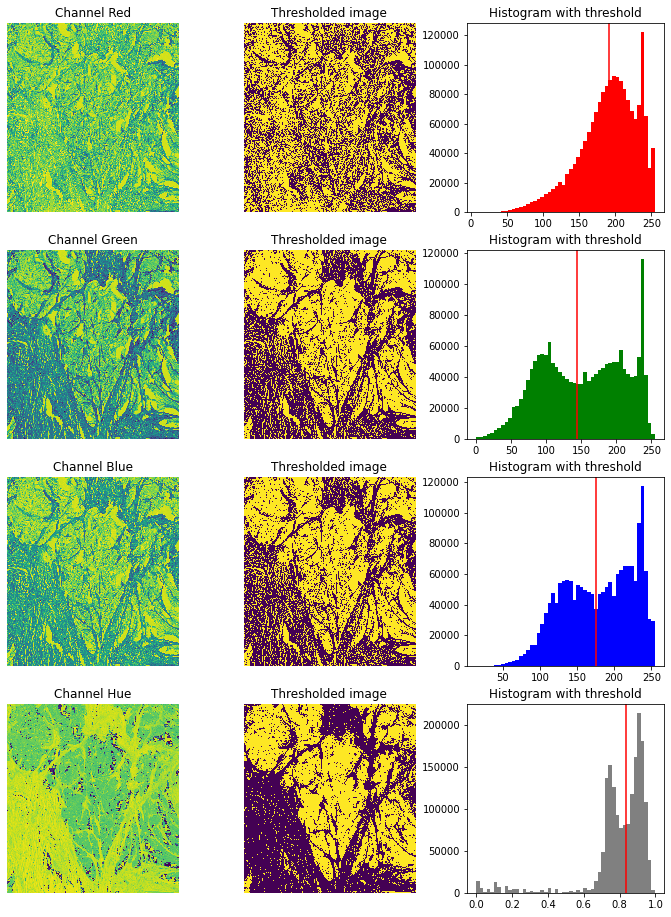

In [8]:
# Plot image, filtered image and histogram for each channel with best threshold
fig, ax = plt.subplots(4, 3, figsize=(12, 16))
for i in range(3):
    threshold = thresholds[i, int(best_threshold_indexes[i])]
    prediction = adeno_img[:, :, i] > threshold
    ax[i, 0].imshow(adeno_img[:, :, i], interpolation='nearest')
    ax[i, 0].set_title('Channel {}'.format(channel_name[i]))
    ax[i, 0].axis('off')
    ax[i, 1].imshow(adeno_img[:, :, i], interpolation='nearest')
    ax[i, 1].imshow(prediction, interpolation='nearest')
    ax[i, 1].set_title('Thresholded image')
    ax[i, 1].axis('off')
    ax[i, 2].hist(adeno_img[:, :, i].flatten(), bins=50, color=channel_name[i].lower())
    ax[i, 2].axvline(threshold, color='r')
    ax[i, 2].set_title('Histogram with threshold')
threshold = thresholds[3, int(best_threshold_indexes[3])]
prediction = hsv_image[:, :, 0] < threshold
ax[3, 0].imshow(hsv_image[:, :, 0], interpolation='nearest')
ax[3, 0].set_title('Channel {}'.format(channel_name[3]))
ax[3, 0].axis('off')
ax[3, 1].imshow(hsv_image[:, :, 0], interpolation='nearest')
ax[3, 1].imshow(prediction, interpolation='nearest')
ax[3, 1].set_title('Thresholded image')
ax[3, 1].axis('off')
ax[3, 2].hist(hsv_image[:, :, 0].flatten(), bins=50, color='grey')
ax[3, 2].axvline(threshold, color='r')
ax[3, 2].set_title('Histogram with threshold')
plt.suptitle('')
plt.show()

In [9]:
# Print the best threshold among all channels
best_threshold_index = np.argmin(best_thresholds)
print("Best threshold is {} with value {} for Channel {}".format(threshold_names[int(best_threshold_indexes[best_threshold_index])], best_thresholds[best_threshold_index], channel_name[best_threshold_index]))

Best threshold is Triangle with value 0.8359510633680556 for Channel Hue


#### 1.2.3 Best Thresholding (1 pts)

Based on your previous findings, set the best threshold(s) and create the final mask as the variable `mask_thesholding`

In [10]:
mask_thesholding = hsv_image[:, :, 0] < thresholds[3, int(best_threshold_indexes[3])]
mask_thesholding = mask_thesholding.astype(np.uint8)

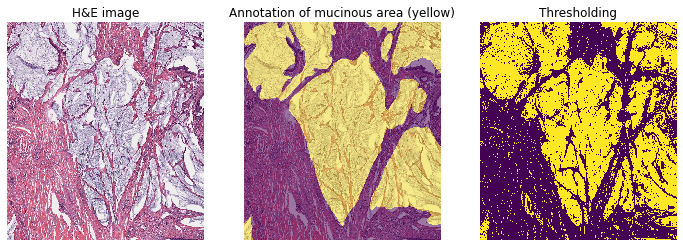

In [11]:
# Display MRI image
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')

ax[2].imshow(mask_thesholding, interpolation='nearest')
ax[2].imshow(mask_thesholding, alpha=0.5, interpolation='nearest')
ax[2].set_title('Thresholding')
ax[2].axis('off')

plt.show()

---

### 1.3 Morphology (5pts)

To proceed, use the best results of the previous model (namely `mask_thesholding`) as the starting point. In this exercise we will try to clean the mask using morphology.

* A (2pts): Try the following operation [closing](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.closing), [opening](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.opening) with [disk](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.disk) size of: $1, 2, 5, 10$. Comment on the quality of the results.

* B (2pts): Try the following operation [remove_small_holes](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_holes), [remove_small_objects](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects) with size of: $10, 50, 100, 500$. Comment on the quality of the results.

* C (1pts): Based on your previous results, can you find a combination of the functions that improve your results? Plot the best result along with the error rate. Save the mask as the variable `mask_morph`

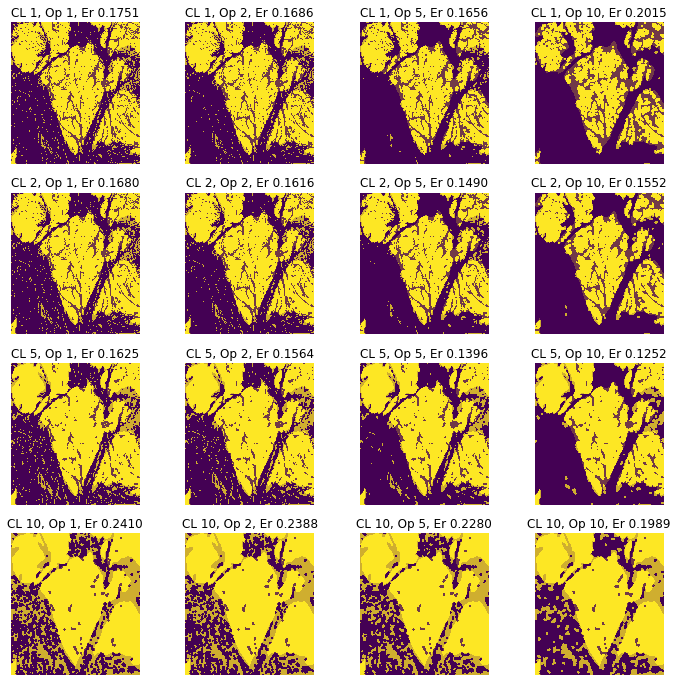

In [12]:
# Closing, opening and disk on the mask_thresholding
from skimage.morphology import disk, binary_closing, binary_opening
sizes = [1, 2, 5, 10]
masks = []
errors = []
for closing_size in sizes:
    for opening_size in sizes:
        mask = binary_closing(mask_thesholding, disk(closing_size))
        mask = binary_opening(mask, disk(opening_size))
        error = error_rate(mask, adeno_gt)
        errors.append(error)
        masks.append(mask)
# Display MRI image
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(masks[i * 4 + j], interpolation='nearest')
        ax[i, j].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
        ax[i, j].set_title('CL {}, Op {}, Er {:.4f}'.format(sizes[i], sizes[j], errors[i * 4 + j]))
        ax[i, j].axis('off')
plt.show()



The best combinations of (closing_size, opening_size) is (5, 10) with an error of 0.1283

/var/folders/_m/cfjw04yj7wg94_lwr7cksb780000gn/T/ipykernel_70880/2506127819.py:8: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  mask = remove_small_holes(mask_thesholding, hole_size)


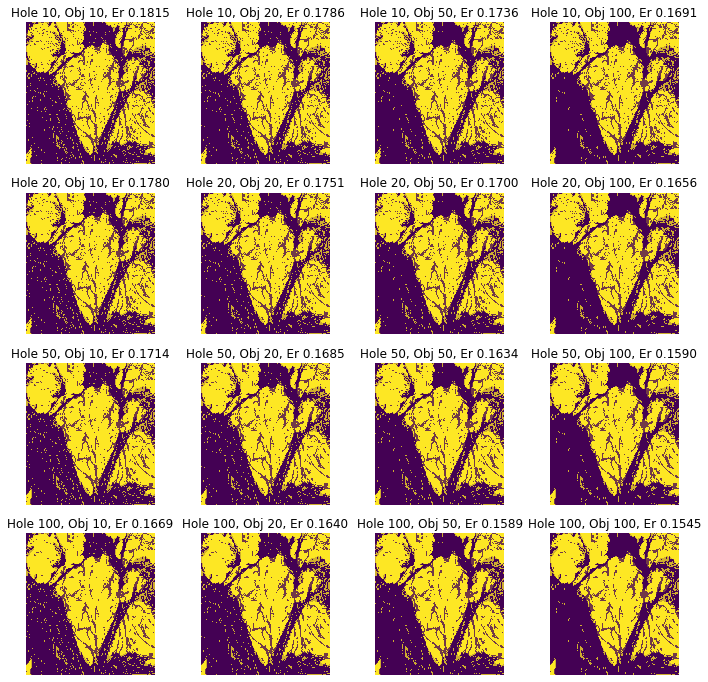

In [13]:
# remove_small_holes, remove_small_objects on the mask_thresholding
from skimage.morphology import remove_small_holes, remove_small_objects
sizes = [10, 20, 50, 100]
masks = []
errors = []
for hole_size in sizes:
    for object_size in sizes:
        mask = remove_small_holes(mask_thesholding, hole_size)
        mask = remove_small_objects(mask, object_size)
        error = error_rate(mask, adeno_gt)
        errors.append(error)
        masks.append(mask)
# Display MRI image
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(masks[i * 4 + j], interpolation='nearest')
        ax[i, j].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
        ax[i, j].set_title('Hole {}, Obj {}, Er {:.4f}'.format(sizes[i], sizes[j], errors[i * 4 + j]))
        ax[i, j].axis('off')
plt.show()

The best option of (hole_size, object_size) is (100, 100)

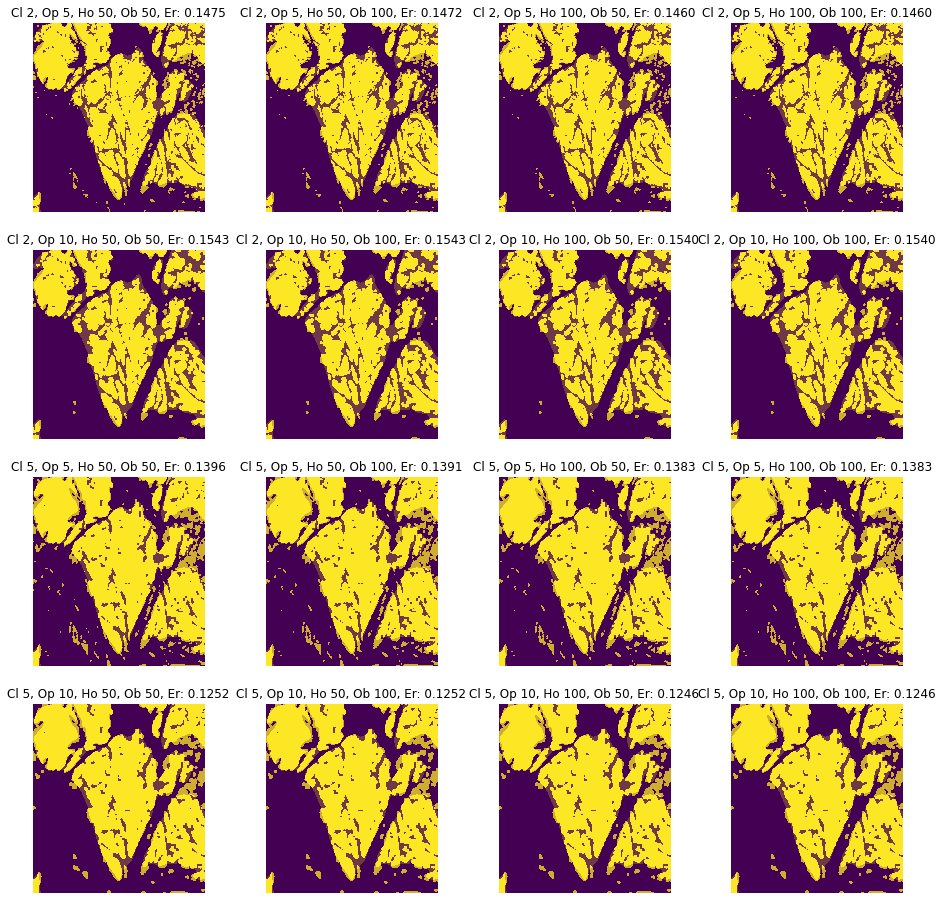

In [14]:
# Apply remove_small_holes, remove_small_objects on the mask closed and opened
closing_sizes = [2, 5]
opening_sizes = [5, 10]
hole_sizes = [50, 100]
object_sizes = [50, 100]
masks = []
errors = []
for closing_size in closing_sizes:
    for opening_size in opening_sizes:
        mask = binary_closing(mask_thesholding, disk(closing_size))
        mask = binary_opening(mask, disk(opening_size))
        for hole_size in hole_sizes:
            for object_size in object_sizes:
                mask = remove_small_holes(mask, hole_size)
                mask = remove_small_objects(mask, object_size)
                error = error_rate(mask, adeno_gt)
                errors.append(error)
                masks.append(mask)
# Display MRI image
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(masks[i * 4 + j], interpolation='nearest')
        ax[i, j].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
        ax[i, j].set_title('Cl {}, Op {}, Ho {}, Ob {}, Er: {:.4f}'.format(closing_sizes[i//2], opening_sizes[i%2], hole_sizes[j//2], object_sizes[j%2], errors[i * 4 + j]))
        ax[i, j].axis('off')
plt.show()

The best result is obtained for the following combination:
- Closing: 5
- Opening: 10
- Holes: 100
- Object: 50 or 100

In [15]:
mask_morph = masks[np.argmin(errors)]

---
### 1.4 Region growing (5pts)

In this exercise you will implement from scratch your own region growing algorithm. Choose one of the image channel (R/G/B/H) as the source image. You can use multiple seed point to achieve better results. Plot the best result along with the error rate. Save the mask as the variable `mask_region`.

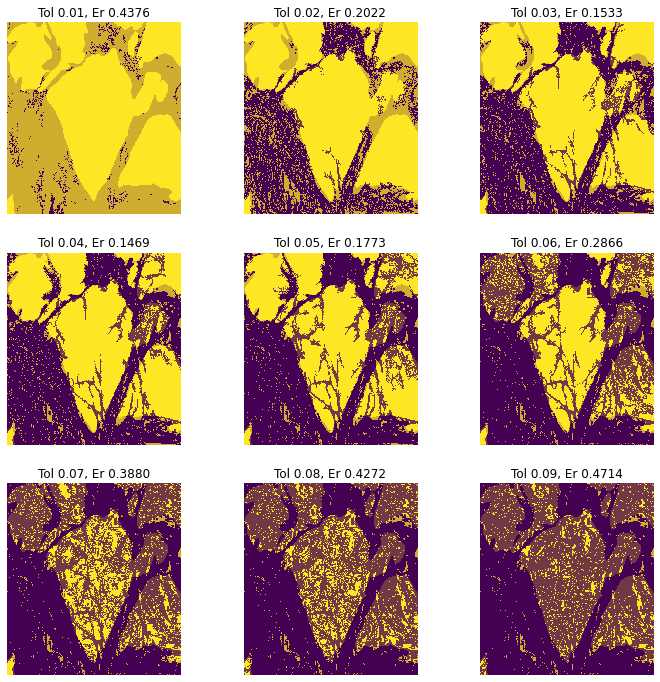

In [16]:
# Compute region growing

from skimage.segmentation import flood
hue_image = hsv_image[:, :, 0]
# Select the seed points given gt image
seeds = np.where(adeno_gt == 0)
seeds = np.array(seeds).T
random_seeds = seeds[np.random.choice(seeds.shape[0], 100, replace=False), :]
# Compute region growing
tolerance_thresholds = [x/100 for x in range(1, 10)]
masks = []
for tolerance in tolerance_thresholds:
    mask_region = np.ones_like(hue_image)
    for seed in random_seeds:
        new_mask = flood(hue_image, (seed[0], seed[1]), tolerance=tolerance)
        mask_region = np.logical_and(mask_region, np.logical_not(new_mask).astype(int))
    masks.append(mask_region)
# Display masks for each threshold with error
errors = [error_rate(mask, adeno_gt) for mask in masks]
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        mask_region = masks[i * 3 + j]
        error = errors[i * 3 + j]
        ax[i, j].imshow(mask_region, interpolation='nearest')
        ax[i, j].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
        ax[i, j].set_title('Tol {}, Er {:.4f}'.format(tolerance_thresholds[i * 3 + j], error))
        ax[i, j].axis('off')
plt.show()

In [17]:
# Best mask is for tolerance 0.03
mask_region = masks[np.argmin(errors)]

---
### 1.5 Method comparison (1pt)

In this section we display the overall outputs. Please make sure that you create the variables `mask_thesholding`, `mask_morph`, and `mask_region` to properly display the output. Comment on the results and what you think would be the best approach.

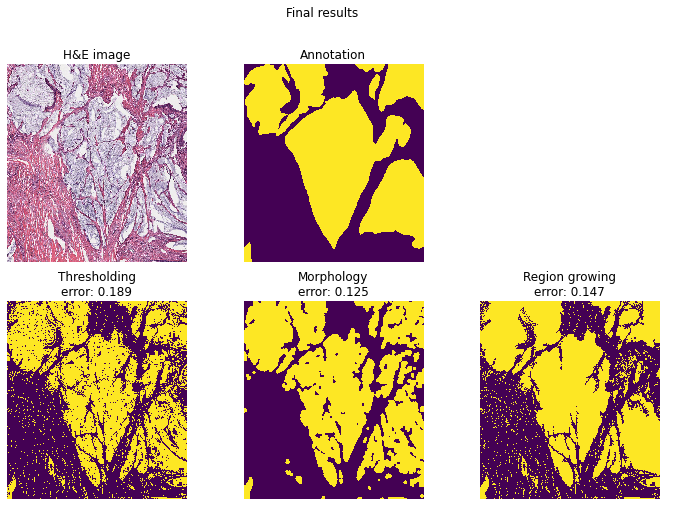

In [18]:
error_th = 1- (mask_thesholding == adeno_gt).mean()
error_morph = 1- (mask_morph == adeno_gt).mean()
error_region = 1- (mask_region == adeno_gt).mean()


# Display MRI image
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Plot image
ax[0, 0].imshow(adeno_img, interpolation='nearest')
ax[0, 0].set_title('H&E image'.format(im_h, im_w))

# Plot image with overlay
ax[0, 1].imshow(adeno_gt, interpolation='nearest')
ax[0, 1].set_title('Annotation')

# Plot estimation using thresholding
ax[1, 0].imshow(mask_thesholding, interpolation='nearest')
ax[1, 0].set_title('Thresholding\nerror: {:.3f}'.format(error_th))

# Plot estimation using Contour detection
ax[1, 1].imshow(mask_morph, interpolation='nearest')
ax[1, 1].set_title('Morphology\nerror: {:.3f}'.format(error_morph))


# Plot estimation using Region growing
ax[1, 2].imshow(mask_region, interpolation='nearest')
ax[1, 2].set_title('Region growing\nerror: {:.3f}'.format(error_region))


[a.axis('off') for a in ax.ravel()]


plt.suptitle("Final results")
plt.show()

## Comments
The lowest error is achieved with morphology applied on Thresholding. The region growing mask achieves better results than the thresholding one, therefore we could try applying morphology techniques on region growing.

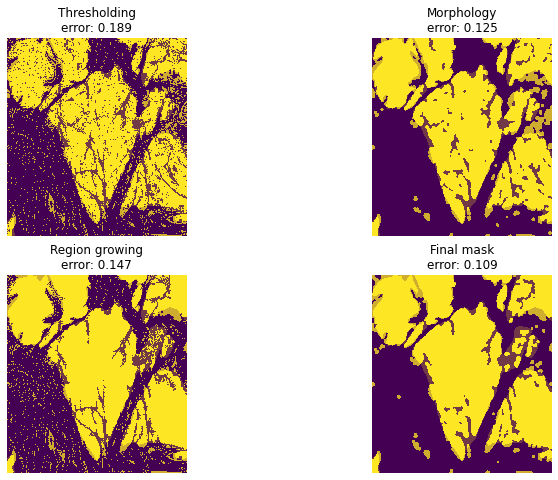

In [19]:
mask = binary_closing(mask_region, disk(5))
mask = binary_opening(mask, disk(10))
mask = remove_small_holes(mask, 100)
mask = remove_small_objects(mask, 50)
error = error_rate(mask, adeno_gt)
# Display MRI image of mask thresholding, morphology, region growing and final mask
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].imshow(mask_thesholding, interpolation='nearest')
ax[0, 0].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
ax[0, 0].set_title('Thresholding\nerror: {:.3f}'.format(error_th))
ax[0, 0].axis('off')
ax[0, 1].imshow(mask_morph, interpolation='nearest')
ax[0, 1].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
ax[0, 1].set_title('Morphology\nerror: {:.3f}'.format(error_morph))
ax[0, 1].axis('off')
ax[1, 0].imshow(mask_region, interpolation='nearest')
ax[1, 0].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
ax[1, 0].set_title('Region growing\nerror: {:.3f}'.format(error_region))
ax[1, 0].axis('off')
ax[1, 1].imshow(mask, interpolation='nearest')
ax[1, 1].imshow(adeno_gt, alpha=0.25, interpolation='nearest')
ax[1, 1].set_title('Final mask\nerror: {:.3f}'.format(error))
ax[1, 1].axis('off')
plt.show()


# ---
## Part 2: Axon segmentations (10 points)

#### Intro 

Axon segmentation is vital to neuroscience research as it enables the study of neurons' morphology and connectivity. We will conduct two exercises to evaluate the impact of your segmentation algorithms under different independent artefacts. Each exercise consists of a synthetic **Ground Truth (GT)** and two more images simulating a specific artifact.

The **Ground Truth**  has tree main compartments. 1) The inner part of the axon. 2) The outer layer of the axon (called myelin) and the extracellular slace (the background of the image). 

The task consists into segmenting the three main compartments in the image to compute the inner-axon and outer-axon radii distribution.


To compute the radii, we suggest the following approximation.
$$\hat{r}_{I}= \sqrt{\frac{A_{yellow}}{\pi}}$$
$$\hat{r}_{O}= \sqrt{\frac{A_{yellow} + A_{blue}}{\pi}}$$
Where **A** is the corresponding area of the comparments. 
**Using this image as reference** 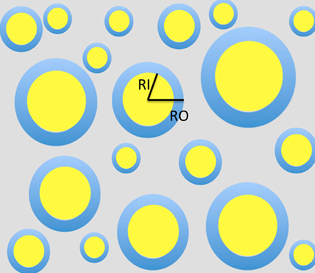

#### Artifacts simulated:

Excercise 1) Two images with different levels of SNR (signal to noise ratio). The images have rician noise.
Exercise  2) Two images adquired using a fraction of the fourier space. Only Lowest frequency are used to reconstruct the image. (simulating fast aquisitions in MRI)

Ensure your algorithm works on the GT before you go to the test cases with artifacts. Apply any preprocessing needed to the image. The preprocessing can be different for each type of image.

### Tasks

For each exercise we ask to:

1) Segment the images with the following colors: blue the inner part of the axon, red the outer part of the axon (myelin) and white for the backround(example) 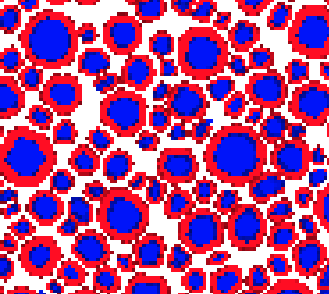

2) Count the number of axons obtained in the sample, calculate the radii for each axons, and display a radii histogram for the each of the images(GT and test cases).

In the exercises, assume that each pixel side is $(0.1 \mu m)$, i.e. a pixel has an area of $(0.01 \mu m^2 )$

## Grading 
The answers does not have to be perfect, they just be a good approximation.

1. Developing an algorithm that works for the two GT images. **(3 points)** 
2. Use preprosesing to prepare the images with SNR and the Low frequencies.  (**1 point** for SNR preprocesing , **1 point** for Low-frequency images preprocesing)
3. Running the algorithm in the test images. **1/2 point** SNR, **1/2 point** Low freqs
4. Computing and plotting radii distributions **(1 point)**
5. Explaining and discussing your implementation. **(3 points )**
    Try to be specific, not necessarily long. In the discussion include:
 1. What worked? 
 2. What did not work?
 3. Why do you think it does not work? 
 4. How could you improve your algorithms as future work?  Try to avoid general comments like "using deep learning" 
 
**Extra points: Real data example (3 points), the algorithm should display a _good enough_ segmentation.**

### 2.1 SNR

../labs/data


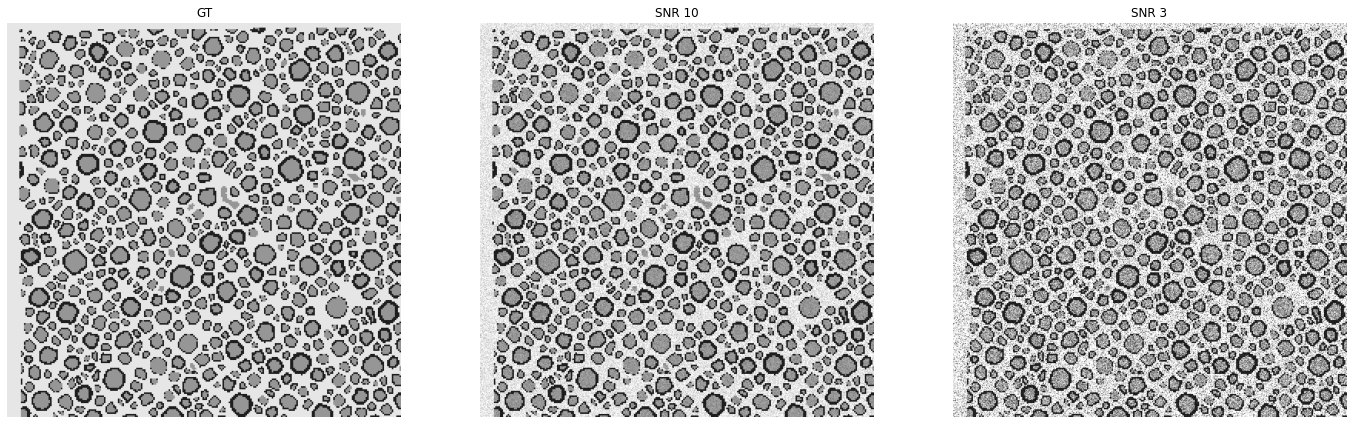

In [4]:
import cv2
import matplotlib.pyplot as plt

data_base_path = os.path.join(os.pardir, 'labs/data')
print(data_base_path)
data_folder = 'lab-01-data'

path_folder = os.path.join(data_base_path, data_folder) + '/' 

files = ["GT_0.png"  , "test_0_0.png" , "test_0_1.png"]
gt_0 = cv2.imread(path_folder+ files[0])
snr_10 = cv2.imread(path_folder+ files[1])
snr_3 = cv2.imread(path_folder+ files[2])

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.1.1 Preprocessing 

 % add your images after preprocessing


Denoising with total variation


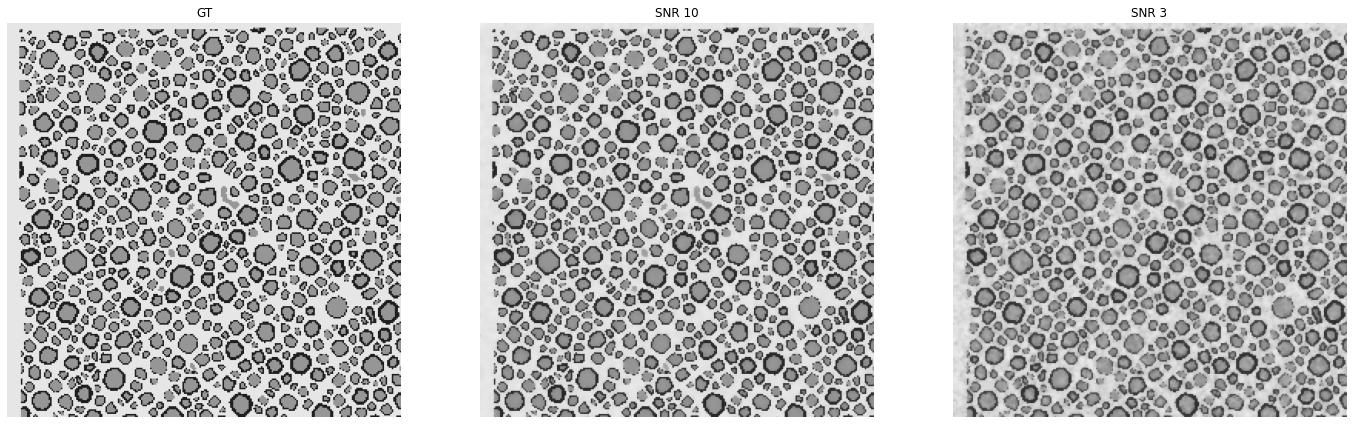

In [5]:
# Denoise with total variation
from skimage.restoration import denoise_tv_chambolle

# Denoise with total variation
print("Denoising with total variation")
snr_10 = denoise_tv_chambolle(snr_10, weight=0.1, channel_axis=-1)
snr_3 = denoise_tv_chambolle(snr_3, weight=0.2, channel_axis=-1)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), [gt_0, snr_10, snr_3], im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

#### Best results obtained with total variation filter


### 2.1.2 Results Segmetations

In [118]:
# Segment images into three classes with multi otsu
from skimage.filters import threshold_multiotsu
from skimage.color import label2rgb

thresholds_10 = threshold_multiotsu(snr_10[:, :, 0])
thresholds_3 = threshold_multiotsu(snr_3[:, :, 0])

regions_10 = np.digitize(snr_10, bins=thresholds_10)
regions_3 = np.digitize(snr_3, bins=thresholds_3)

length = 1024
color_map = {0: np.array([255, 0, 0]), 1: np.array([0, 0, 255]), 2: np.array([255, 255, 255])}
for i in range(length):
    for j in range(length):
        regions_10[i,j] = color_map[regions_10[i,j,0]]
        regions_3[i,j] = color_map[regions_3[i,j,0]]

snr_10, snr_3 = regions_10, regions_3



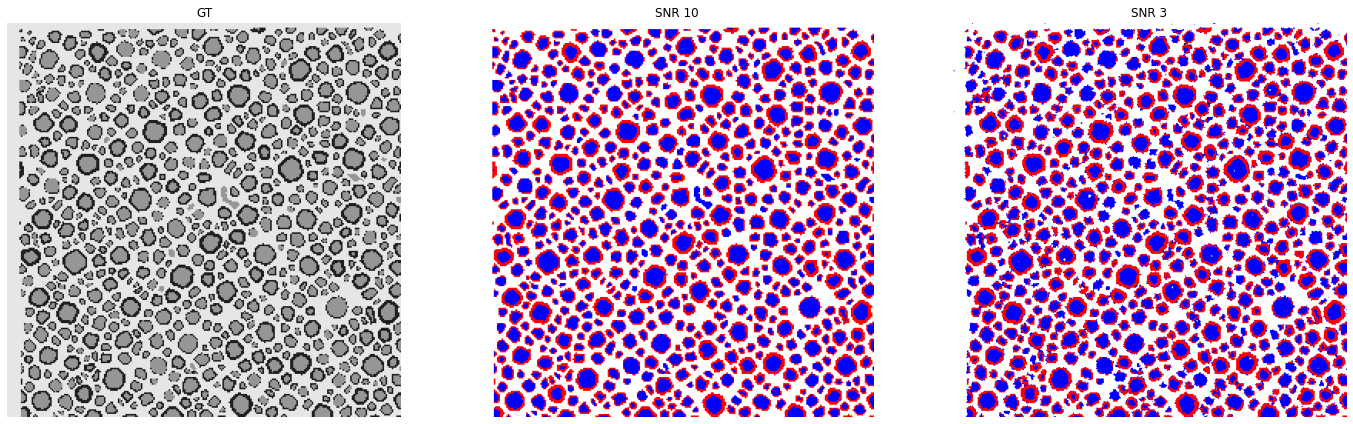

In [120]:
images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.1.3 Radii histrograms 

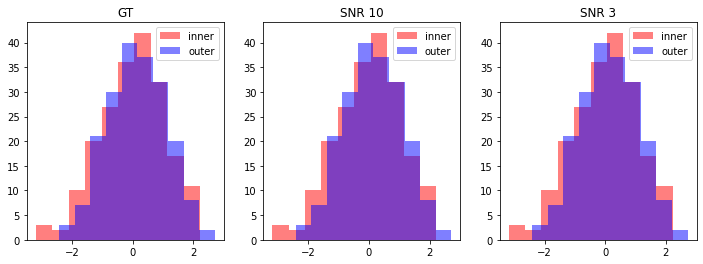

In [121]:
## results Radii distribution. proposal feel free to change it
import numpy as np


rads_outer = np.random.normal(0, 1, 200)
rads_inner = np.random.normal(0, 1, 200)


rads_gt = [ rads_inner ,rads_outer]
rads_test0 = [ rads_inner ,rads_outer]  # your result
rads_test1 = [ rads_inner ,rads_outer]  # your result

all_rads= [rads_gt , rads_test0 , rads_test1] 

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0]  , color = "red" , label = "inner" ,alpha= 0.5)
    ax.hist(rads[1]  , color = "blue" , label = "outer" ,alpha= 0.5)
    ax.legend()
    ax.set_title(nm)
plt.show()


### 2.2 Low frequencies

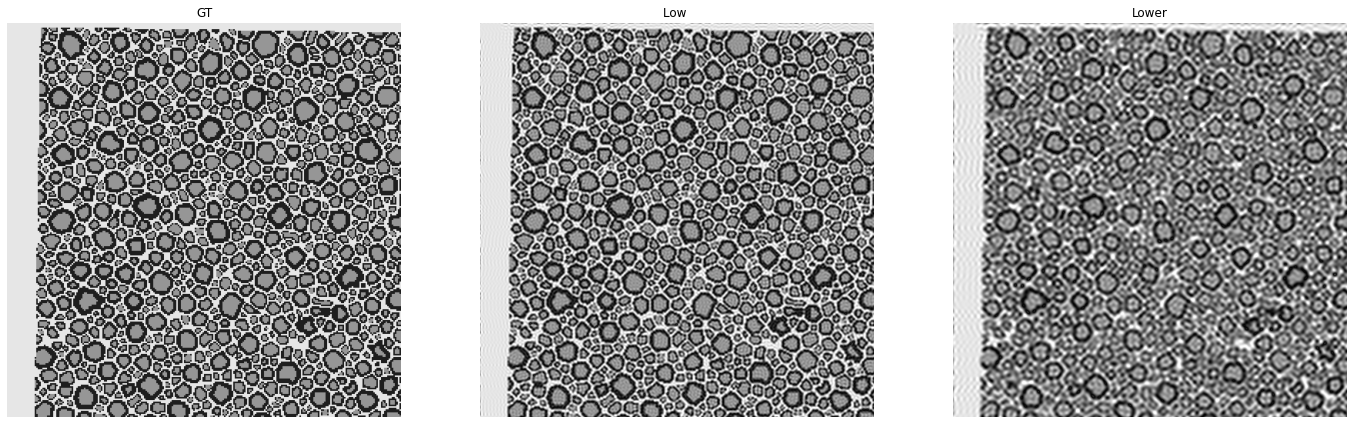

In [6]:

files = ["GT_3.png"  , "test_3_0.png" , "test_3_1.png"]
path = "data/"
gt_3 = cv2.imread(path_folder+ files[0])
lowfreq0 = cv2.imread(path_folder+ files[1])
lowfreq1 = cv2.imread(path_folder+ files[2])

images = [gt_3 , lowfreq0, lowfreq1]
im_names = ["GT" , "Low " , "Lower"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2.1 Preprocessing

In [16]:
# Apply wiener filter
from skimage.restoration import unsupervised_wiener
from scipy.signal import convolve2d

matrix = np.zeros((1024, 1024))
matrix[512, 512] = 1
psf0 = convolve2d(lowfreq0[:, :, 0], matrix, mode='same')
psf1 = convolve2d(lowfreq1[:, :, 0], matrix, mode='same')

convolved0 = convolve2d(lowfreq0[:, :, 0], psf0, mode='same')
convolved1 = convolve2d(lowfreq1[:, :, 0], psf1, mode='same')

rng = np.random.default_rng()

noised0 = convolved0 + rng.normal(0, convolved0.std(), convolved0.shape)
noised1 = convolved1 + rng.normal(0, convolved1.std(), convolved1.shape)

wiener0 = unsupervised_wiener(noised0, psf0)
wiener1 = unsupervised_wiener(noised1, psf1)

NameError: name 'gt_3' is not defined

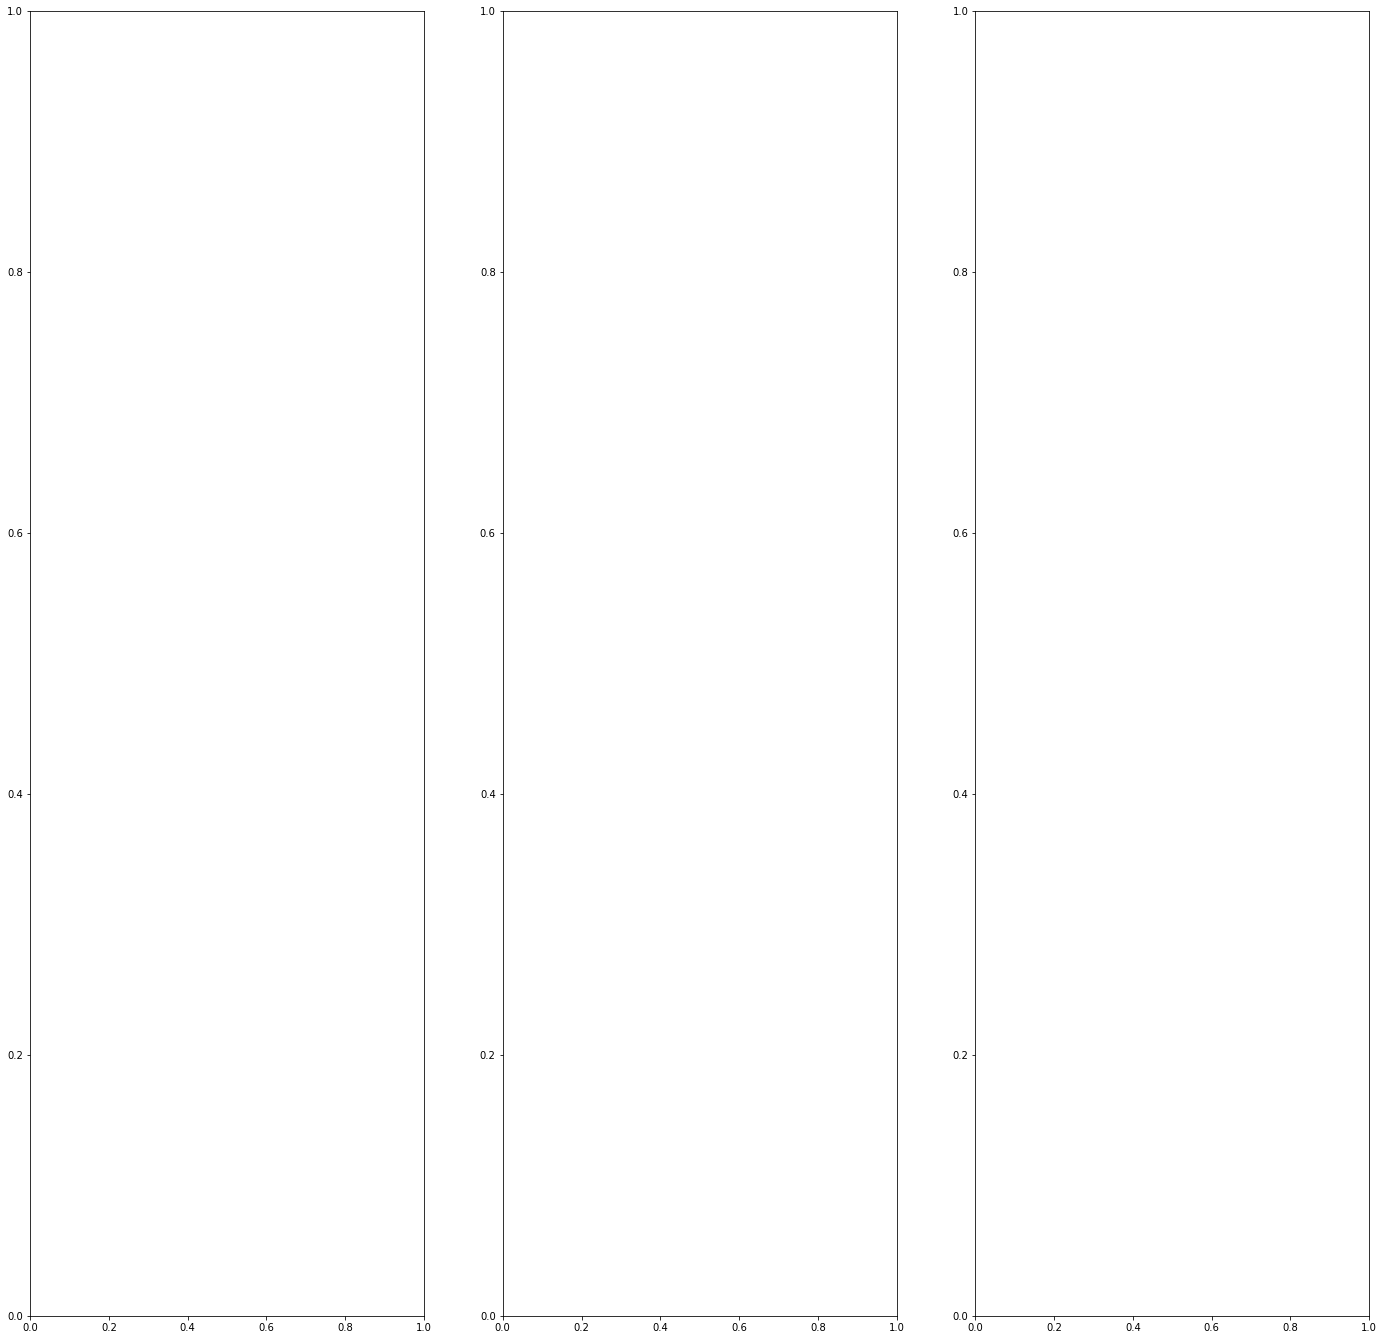

In [ ]:
# Display results
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), [gt_3, wiener0, wiener1], im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2.2 Results Segmetations

### 2.2.3 Radii histrograms

In [1]:
## results Radii distribution. proposal feel free to change it
import numpy as np


rads_outer = np.random.normal(0, 1, 200)
rads_inner = np.random.normal(0, 1, 200)


rads_gt = [ rads_inner ,rads_outer]
rads_test0 = [ rads_inner ,rads_outer]  # your result
rads_test1 = [ rads_inner ,rads_outer]  # your result

all_rads= [rads_gt , rads_test0 , rads_test1] 

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0]  , color = "red" , label = "inner" ,alpha= 0.5)
    ax.hist(rads[1]  , color = "blue" , label = "outer" ,alpha= 0.5)
    ax.legend()
    ax.set_title(nm)
plt.show()


NameError: name 'gt_0' is not defined

### 2.5 Not mandatory exercise, Real data ( 3 points )

The points are given just by having a good enough segmentation.

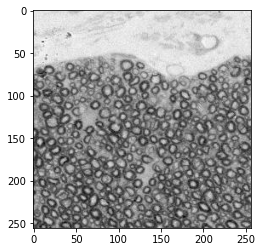

In [26]:
# Add your implementation and discussion
import cv2

files = ["extra_point.png" ]
real_data = cv2.imread(path_folder+ files[0])

plt.imshow(real_data[:256, :256])